In [7]:
import numpy as np
import time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import warnings
import os
import pickle
os.environ["PYTHONWARNINGS"] = "ignore"
import warnings
warnings.filterwarnings("ignore")
def get_hit_k(preds, ground, k = 10):
  pred_labels = np.zeros(preds.shape)
  for i in range(preds.shape[0]):
    idxes = np.argsort(preds[i, :])[::-1][:k]
    idxes = np.array([idx for idx in idxes if preds[i, idx]>0])
    pred_labels[i, idxes] = 1
  return sum(sum(np.array(ground, dtype=np.bool) \
                       & np.array(pred_labels, dtype=np.bool))) / np.sum(ground)


def get_clf(model_name, emb_type, emb_size):
  clf_path = 'clf_save/{}_{}{}.pkl'.format(model_name, emb_type, emb_size)
  if os.path.exists(clf_path):
    with open(clf_path, 'rb') as fid:
      classif = pickle.load(fid)
  else:
    if model_name == "lr":
      classif = OneVsRestClassifier(LogisticRegression())
    elif model_name == "svm":
      classif = OneVsRestClassifier(SVC(kernel='linear',probability=True), n_jobs=20)
    elif model_name == "mlp":
      classif = OneVsRestClassifier(MLPClassifier(), n_jobs=20)
    s = time.time()
    classif.fit(X_train, Y_train)
    e = time.time()
    print("time", e - s)
    with open(clf_path, 'wb') as fid:
      pickle.dump(classif, fid)
  return classif


In [24]:
word_acc = dict(
  [(emb_size, dict(
      [(clf_name, {}) for clf_name in ["lr", "svm", "mlp"]]
    ) 
  ) for emb_size in [50, 100, 150, 200, 250, 300]]
)

for emb_size in [50, 100, 150, 200, 250, 300]:
  data = np.load("data/word_{}d.npy".format(emb_size), allow_pickle=True)[()]
  X_train, Y_train = data["trn"]
  X_val, Y_val = data["val"]
  X_tst, Y_tst = data["tst"]
  for clf_name in ["lr", "svm", "mlp"]:
    classif = get_clf(clf_name, "word", emb_size)
    pred_tst = classif.predict_proba(X_tst)
    for k in [1, 2, 5, 10, 50]:
      word_acc[emb_size][clf_name][k] = get_hit_k(pred_tst, Y_tst, k)

# phrase

In [9]:
phrase_acc = dict(
  [(emb_size, dict(
      [(clf_name, {}) for clf_name in ["lr", "svm", "mlp"]]
    ) 
  ) for emb_size in [50, 100, 150, 200]]
)

for emb_size in [50, 100, 150, 200]:
  data = np.load("data/phrase_{}d.npy".format(emb_size), allow_pickle=True)[()]
  X_train, Y_train = data["trn"]
  X_val, Y_val = data["val"]
  X_tst, Y_tst = data["tst"]
  for clf_name in ["lr", "svm", "mlp"]:
    classif = get_clf(clf_name, "phrase", emb_size)
    pred_tst = classif.predict_proba(X_tst)
    for k in [1, 2, 5, 10, 50]:
      phrase_acc[emb_size][clf_name][k] = get_hit_k(pred_tst, Y_tst, k)

time 722.2039077281952
time 138.03082656860352
time 746.0128943920135
time 666.1711282730103
time 178.43770360946655
time 922.7475826740265


# Plot

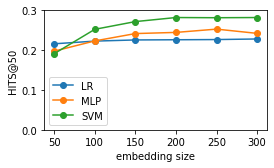

In [26]:
import matplotlib.pyplot as plt


plt.figure(figsize=(4,2.2))
xaxis = [50, 100, 150, 200, 250, 300]
k = 50
for clf_name in ["lr", "mlp", "svm"]:
  plt.plot(xaxis, [word_acc[es][clf_name][k] for es in xaxis],
           'o-', label=clf_name.upper())
plt.legend()
plt.xlabel("embedding size")
plt.ylabel("HITS@50")
plt.ylim(0, 0.3)
plt.xticks(xaxis)
plt.savefig("emb_size_hits_50.png", dpi=600, bbox_inches="tight")
plt.show()


In [30]:
[ round(word_acc[200]["svm"][k]*100, 2) for k in [1, 2, 5, 10, 50]]

[5.87, 9.31, 13.91, 17.45, 28.16]

In [31]:
[ round(phrase_acc[200]["svm"][k]*100, 2) for k in [1, 2, 5, 10, 50]]

[6.45, 9.45, 14.64, 18.42, 28.26]